
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/81_Audio_Mel_Spectrograms.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🎧 Audio Processing: Jak AI słyszy świat? (Mel-Spectrogram)

Modele takie jak Whisper czy Siri nie "słuchają" fali dźwiękowej bezpośrednio. One "patrzą" na jej reprezentację wizualną.

**Transformacja:**
1.  **Waveform (Czas):** Zwykły wykres amplitudy (to, co widzisz w Audacity). Mało czytelne dla AI.
2.  **STFT (Short-Time Fourier Transform):** Dzielimy dźwięk na klatki (np. co 20ms) i robimy FFT. Otrzymujemy mapę: Czas x Częstotliwość.
3.  **Mel-Spectrogram:** Ściskamy oś częstotliwości, używając **Skali Melowej**.
    *   Niskie tony (bas) są rozciągnięte (ważne dla mowy).
    *   Wysokie tony (pisk) są ściśnięte (mało ważne).

W tym notatniku wygenerujemy dźwięk, posłuchamy go i zamienimy na "obraz", który rozumie sieć neuronowa.

In [ ]:
# Instalacja biblioteki do audio (librosa to standard)
!uv pip install librosa numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

# Konfiguracja
SR = 22050 # Sample Rate (standardowa jakość audio)
DURATION = 5 # Sekundy

print(f"Będziemy przetwarzać {SR * DURATION} próbek.")

## Generowanie Dźwięku (Chirp Signal)

Stworzymy sztuczny sygnał, który zmienia częstotliwość w czasie (tzw. "Sweep" lub "Chirp").
Zaczniemy od niskiego basu (100 Hz) i pójdziemy do wysokiego pisku (8000 Hz).
Dzięki temu idealnie zobaczymy różnicę między skalą liniową a Melową.

🔊 Posłuchaj sygnału:


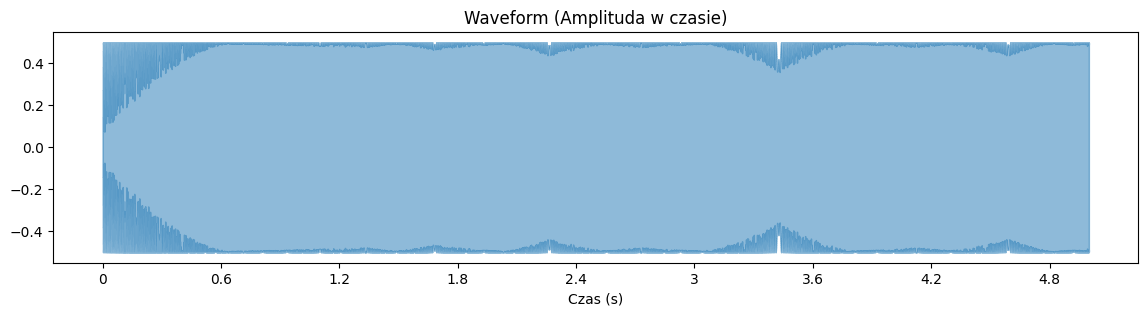

Widać tylko, że coś 'gęstnieje', ale nie widać jakie to nuty.


In [3]:
# Oś czasu
t = np.linspace(0, DURATION, int(SR * DURATION))

# Generujemy sygnał "Chirp" (częstotliwość rośnie liniowo)
# f(t) zmienia się od 100 Hz do 8000 Hz
freqs = np.linspace(100, 8000, len(t))
phase = 2 * np.pi * np.cumsum(freqs) / SR
signal = 0.5 * np.sin(phase)

# Posłuchajmy tego! (Działa w Colab/Jupyter)
print("🔊 Posłuchaj sygnału:")
ipd.display(ipd.Audio(signal, rate=SR))

# Wizualizacja fali (Waveform)
plt.figure(figsize=(14, 3))
librosa.display.waveshow(signal, sr=SR, alpha=0.5)
plt.title("Waveform (Amplituda w czasie)")
plt.xlabel("Czas (s)")
plt.show()

print("Widać tylko, że coś 'gęstnieje', ale nie widać jakie to nuty.")

## Krok 1: STFT (Spektrogram Liniowy)

Używamy **Szybkiej Transformaty Fouriera (FFT)** na małych kawałkach sygnału.
Oś Y to częstotliwość w Hz (liniowo).

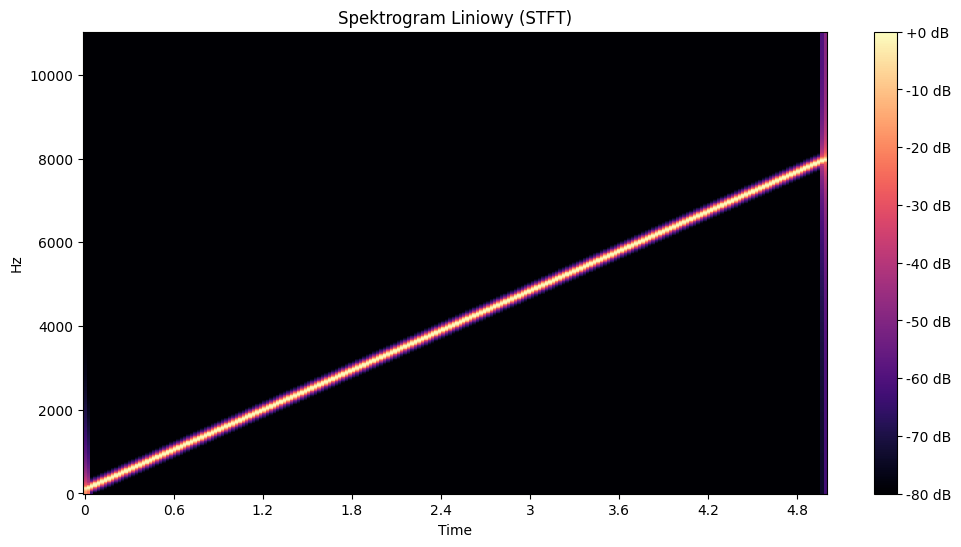

ANALIZA:
Widzisz prostą linię idącą w górę? To nasza rosnąca częstotliwość.
Na osi liniowej (Hz) zmiana o 1000 Hz wygląda tak samo na dole i na górze wykresu.


In [4]:
# Obliczamy STFT
# n_fft = długość okna (ile próbek bierzemy do jednego FFT)
# hop_length = przesunięcie (co ile próbek robimy nowe okno)
stft = librosa.stft(signal, n_fft=2048, hop_length=512)

# Zamieniamy na decybele (skala logarytmiczna amplitudy - tak słyszy ucho głośność)
spectrogram_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(spectrogram_db, sr=SR, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title("Spektrogram Liniowy (STFT)")
plt.show()

print("ANALIZA:")
print("Widzisz prostą linię idącą w górę? To nasza rosnąca częstotliwość.")
print("Na osi liniowej (Hz) zmiana o 1000 Hz wygląda tak samo na dole i na górze wykresu.")

## Krok 2: Mel-Spectrogram (Jak słyszy człowiek?)

Dla człowieka różnica między 100 Hz a 200 Hz to cała oktawa (dużo).
Różnica między 10000 Hz a 10100 Hz jest niesłyszalna.

**Skala Melowa** "rozciąga" dół wykresu i "ściska" górę.
Dzięki temu AI skupia się na mowie (która jest nisko), a ignoruje szumy (które są wysoko).

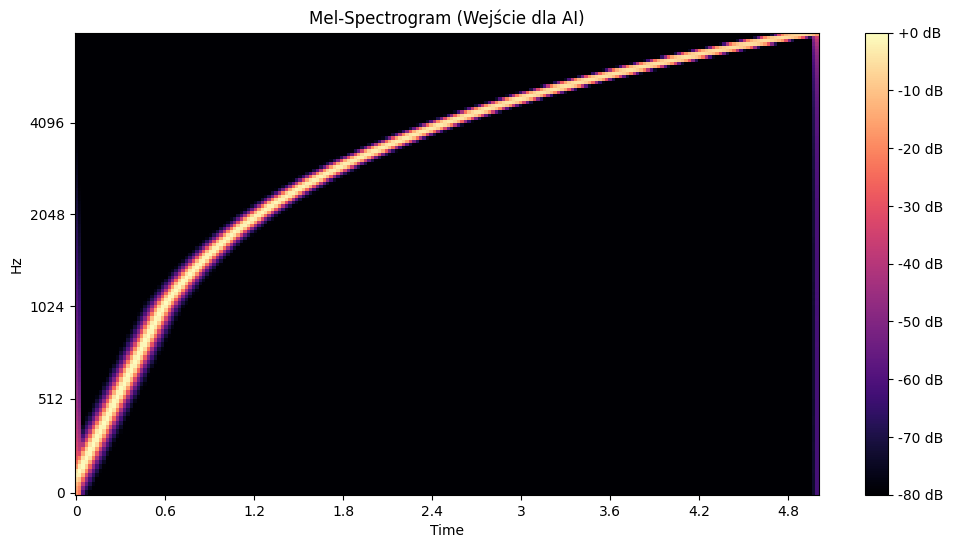

ANALIZA:
Spójrz na linię. Nie jest już prosta! Jest wygięta (logarytmiczna).
Niskie częstotliwości zajmują więcej miejsca na wykresie.
To jest dokładnie ten obrazek, który wchodzi do modelu Whisper.


In [5]:
# Tworzymy Mel-Spectrogram
# n_mels = 128 (standardowa "wysokość" obrazka dla sieci neuronowych)
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=SR, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(12, 6))
# Zauważ: y_axis='mel'
librosa.display.specshow(mel_spectrogram_db, sr=SR, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram (Wejście dla AI)")
plt.show()

print("ANALIZA:")
print("Spójrz na linię. Nie jest już prosta! Jest wygięta (logarytmiczna).")
print("Niskie częstotliwości zajmują więcej miejsca na wykresie.")
print("To jest dokładnie ten obrazek, który wchodzi do modelu Whisper.")

## 🧠 Podsumowanie: Dźwięk to Obraz

Dla Inżyniera AI (Deep Learning), **Audio to po prostu Computer Vision**.

Gdy zamienisz nagranie na Mel-Spectrogram:
1.  Możesz użyć sieci **CNN** (jak w notatniku 38), żeby klasyfikować dźwięki (szczekanie psa vs klakson).
2.  Możesz użyć **Transformera**, żeby rozpoznawać mowę (Whisper traktuje spektrogram jako sekwencję "patchy", tak jak ViT w notatniku 70).

**Kluczowe parametry w produkcji:**
*   `Sample Rate`: Zazwyczaj 16kHz (dla mowy) lub 44.1kHz (dla muzyki).
*   `n_mels`: Zazwyczaj 80 lub 128 (ilość "pikseli" w pionie).